In [1]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Identity tensor
I = eye(3)

# Direction vector
e1 = I[:,0]
e2 = I[:,1]
e3 = I[:,2]

In [3]:
# Dilatation coefficients
u, Nu, Mu   = symbols(r'u \nu \mu', positive=True)

LambdaH = 1             # Coefficient for homogeneous dilatation
LambdaX = u **(-Nu)     # Coefficient for lengthening in e1 direction (here <1)
LambdaY = u **(-Nu)     # Coefficient for lengthening in e2 direction (here <1)
LambdaZ = u             # Coefficient for lengthening in e3 direction (here >1)

In [4]:
# Deformation matrices
U = I + (LambdaX-1) * np.outer(e1,e1) + (LambdaY-1) * np.outer(e2,e2) + (LambdaZ-1) * np.outer(e3,e3)

# Gradient of the deformation
F = (LambdaH-1) * I + U

# Volume change
J = det(F)

# Right Cauchy-Green strain tensor
C = transpose(F) * F

In [5]:
# Eigenvalues of Right Cauchy-Green strain tensor
Lambda1, Lambda2, Lambda3 = symbols(r'\lambda_1 \lambda_2 \lambda_3')

# Invariants
J, I1, I2 = symbols(r'J I_1 I_2')
JFunction = Lambda1*Lambda2*Lambda3
I1Function = Lambda1**2+Lambda2**2+Lambda3**2
I2Function = Lambda1**2*Lambda2**2 + Lambda2**2*Lambda3**2 + Lambda3**2*Lambda1**2

# Hyperelastic models (incompressible)

# Neo-Hookean
C1           = symbols(r'C_1', positive=True)
C1Function   = Mu / 2
Psi_NH       = C1 * (I1 - 3)

# Mooney-Rivlin
C01, C10, D1 = symbols(r'C_{01} C_{10} D_{1}', positive=True)
C10Function  = Mu / 2 - C01
D1Function   = Mu * (1+Nu) / (3*(1-2*Nu))
Psi_MR       = C01 * (J**Rational(-4,3)*I2 - 3) + C10 * (J**Rational(-2,3)*I1 - 3)

# Gent
Jm           = symbols('J_m')
Psi_Gn       = - Mu*Jm/2 * ln(1 - (I1 - 3) / Jm)

# Demiray
Beta         = symbols(r'\beta')
Psi_Dm       = Mu/2 * (exp(Beta*(I1 - 3)) - 1) / Beta

# Ogden
Alpha        = symbols(r'\alpha')
Psi_Og       = 2*Mu * (Lambda1**Alpha + Lambda2**Alpha + Lambda3**Alpha - 3) / Alpha**2


Psis = [Psi_NH, Psi_MR, Psi_Gn, Psi_Dm, Psi_Og]

In [6]:
for Psi in Psis:

    # Derivative with respect to Lambdas (https://en.wikipedia.org/wiki/Hyperelastic_material: compressible isotropic hyperelastic material)
    PsiLambda = Psi.subs({J:JFunction,I1:I1Function,I2:I2Function})

    T1 = Lambda1*Derivative(PsiLambda, Lambda1)
    T1 = T1.doit()

    T2 = Lambda2*Derivative(PsiLambda, Lambda2)
    T2 = T2.doit()

    T3 = Lambda3*Derivative(PsiLambda, Lambda3)
    T3 = T3.doit()

    T = T1 * np.outer(e1,e1) + T2 *np.outer(e2,e2) + T3 * np.outer(e3,e3)
    T = Matrix(T).doit()
    T = T.subs({JFunction:J,I1Function:I1,I2Function:I2})
    T = simplify(T)
    T = T.subs({JFunction:J,I1Function:I1,I2Function:I2})
    T = T.subs({J:'J',I1:'I_1',I2:'I_2'})
#     display(T)     # Control
    
    # Replace invariants
    T = T.subs({'J':JFunction,'I_1':I1Function,'I_2':I2Function})

    # Replace material constants
    T = T.subs({C1:C1Function, C10:C10Function})

    # Replace Eingenvalues
    Lambdas = C.eigenvals()
    Lambdas = list(Lambdas)
    T = T.subs({Lambda1:sqrt(Lambdas[0]), Lambda2:sqrt(Lambdas[0]), Lambda3:sqrt(Lambdas[1])})
    
    # T11 and T22 are null
    T = T - T[0,0] * I
    T = simplify(T)

    # Other stresses
    J = det(F)                                    # Volume change
    P = J * T * F.inv().transpose()               # Nominal stress
    S = J * F.inv() * T * F.inv().transpose()     # Material stress

    # Define axial responses
    if Psi == Psis[0]:
        print('Neo-Hookean material')
        NH = lambdify((Nu, Mu, u), P[2,2], 'numpy')
    elif Psi == Psis[1]:
        print('Mooney-Rivlin material')
        MR = lambdify((C01, Nu, Mu, u), P[2,2], 'numpy')
    elif Psi == Psis[2]:
        print('Gent material')
        Gn = lambdify((Jm, Nu, Mu, u), P[2,2], 'numpy')
    elif Psi == Psis[3]:
        print('Demiray material')
        Dm = lambdify((Beta, Nu, Mu, u), P[2,2], 'numpy')
    elif Psi == Psis[4]:
        print('Ogden material')
        Og = lambdify((Alpha, Nu, Mu, u), P[2,2], 'numpy')

Neo-Hookean material
Mooney-Rivlin material
Gent material
Demiray material
Ogden material


Stresses at stretch ratio of 1.00:
Neo-Hookean   : 0.000
Mooney-Rivlin : 0.000
Gent          : 0.000
Demiray       : 0.000
Ogden         : 0.000


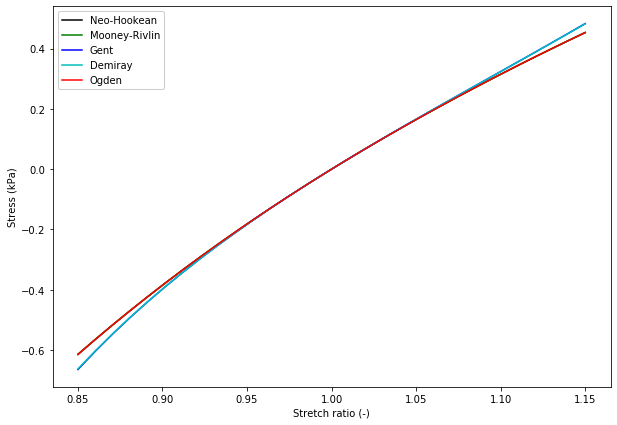

In [8]:
# Plot Results

NuV = 0.5
MuV = 1.15
uV  = 1.
print('Stresses at stretch ratio of %.2f:'%(uV))

# Values
NuV    = 0.5    # Poisson's ratio (-)
MuV    = 1.15   # Shear modulus (kpa)
C01V   = 0.     # Mooney-Rivlin 3rd material constant (kPa) if == 0 => Neo-Hookean
JmV    = 1.     # Gent 3rd material constant (-) if == 1 => ~Neo-Hookean with ln
BetaV  = 1.     # Demiray 3rd material constant (-) if == 1 => ~Neo-Hookean with exp
AlphaV = 2.     # Ogden 3rd material constant (-) if == 2 => Neo-Hookean

Xmin = 0.85
Xmax = 1.15
Delta = 0.01
U33 = np.linspace(Xmin,Xmax,int((Xmax-Xmin)/Delta+1))

plt.rc('figure', figsize=[10,7])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.cla()
ax.plot(U33, NH(NuV, MuV, U33),  color = 'k', linestyle = '-', label='Neo-Hookean')
print('Neo-Hookean   : %.3f'%(NH(NuV, MuV, uV)))
ax.plot(U33, MR(C01V, NuV, MuV, U33),  color = 'g', linestyle = '-', label='Mooney-Rivlin')
print('Mooney-Rivlin : %.3f'%(MR(C01V, NuV, MuV, uV)))
ax.plot(U33, Gn(JmV, NuV, MuV, U33),  color = 'b', linestyle = '-', label='Gent')
print('Gent          : %.3f'%(Gn(JmV, NuV, MuV, uV)))
ax.plot(U33, Dm(BetaV, NuV, MuV, U33),  color = 'c', linestyle = '-', label='Demiray')
print('Demiray       : %.3f'%(Dm(BetaV, NuV, MuV, uV)))
ax.plot(U33, Og(AlphaV, NuV, MuV, U33),  color = 'r', linestyle = '-', label='Ogden')
print('Ogden         : %.3f'%(Og(AlphaV, NuV, MuV, uV)))
ax.set_xlabel('Stretch ratio (-)')
ax.set_ylabel('Stress (kPa)')
# plt.xlim([0.8, 1.2])
# plt.ylim([1, 3])
plt.legend(loc='upper left', frameon=True, framealpha=1)
plt.show()

In [ ]:
# Save Results

Psis2Save = [Psis[0]]   # Constitutive models to save

# Folder for the results
Output_Path = os.path.join('AnalyticalResults')
os.makedirs(Output_Path, exist_ok=True)

for Psi in Psis2Save:
    
    if Psi == Psis[0]:
        FileName = 'NeoHookean_Nu' + str(NuV) + 'Mu' + str(MuV) + '.csv'
        DataFrame = pd.DataFrame({'Stretch Ratio (-)':U33, 'P Stress (kPa)':NH(NuV, MuV, U33)})
        
    if Psi == Psis[1]:
        FileName = 'MooneyRivlin_Nu' + str(NuV) + 'Mu' + str(MuV) + 'C01' + str(C01V) + '.csv'
        DataFrame = pd.DataFrame({'Stretch Ratio (-)':U33, 'P Stress (kPa)':MR(C10V, NuV, MuV, U33)})
        
    if Psi == Psis[2]:
        FileName = 'Gent_Nu' + str(NuV) + 'Mu' + str(MuV) + 'Jm' + str(JmV) + '.csv'
        DataFrame = pd.DataFrame({'Stretch Ratio (-)':U33, 'P Stress (kPa)':Gn(JmV, NuV, MuV, U33)})
    
    if Psi == Psis[3]:
        FileName = 'Demiray_Nu' + str(NuV) + 'Mu' + str(MuV) + 'Beta' + str(BetaV) + '.csv'
        DataFrame = pd.DataFrame({'Stretch Ratio (-)':U33, 'P Stress (kPa)':Dm(BetaV, NuV, MuV, U33)})
        
    if Psi == Psis[4]:
        FileName = 'Ogden_Nu' + str(NuV) + 'Mu' + str(MuV) + 'Alpha' + str(AlphaV) + '.csv'
        DataFrame = pd.DataFrame({'Stretch Ratio (-)':U33, 'P Stress (kPa)':Og(AlphaV, NuV, MuV, U33)})
        
    # Save table and figure
    DataFrame.to_csv(os.path.join(Output_Path, FileName), index=False)